In [13]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import os
import glob
import matplotlib.pyplot as plt

data: np.ndarray = pd.read_csv("/kaggle/input/cities/Cairo.csv").values

In [14]:
# convert date to number of days since 01/01/2020
def days_since_zero_date(date_str: str) -> int:
    # Converting a string to a datetime object
    date_format: str = "%Y-%m-%d"
    
    date_obj = datetime.strptime(date_str, date_format)
    
    zero_date = datetime.strptime("2020-01-01", date_format)
    delta = date_obj - zero_date
    days = delta.days
    return days

data[:, 0] = np.vectorize(days_since_zero_date)(data[:, 0])

data = data.astype("float")
print(data)

[[0.000e+00 1.350e+01 6.600e+01 1.000e+01]
 [1.000e+00 1.210e+01 4.900e+01 2.010e+01]
 [2.000e+00 1.200e+01 5.600e+01 2.560e+01]
 ...
 [1.891e+03 1.680e+01 6.200e+01 1.310e+01]
 [1.892e+03 1.760e+01 6.100e+01 1.340e+01]
 [1.893e+03 1.800e+01 6.000e+01 9.900e+00]]


In [15]:
ratio = 0.9
index = int(data.shape[0] * ratio)
train_data = data[:index]
test_data = data[index:]
print(train_data)

[[0.000e+00 1.350e+01 6.600e+01 1.000e+01]
 [1.000e+00 1.210e+01 4.900e+01 2.010e+01]
 [2.000e+00 1.200e+01 5.600e+01 2.560e+01]
 ...
 [1.701e+03 3.080e+01 4.600e+01 1.970e+01]
 [1.702e+03 3.180e+01 4.400e+01 1.700e+01]
 [1.703e+03 3.170e+01 4.100e+01 1.890e+01]]


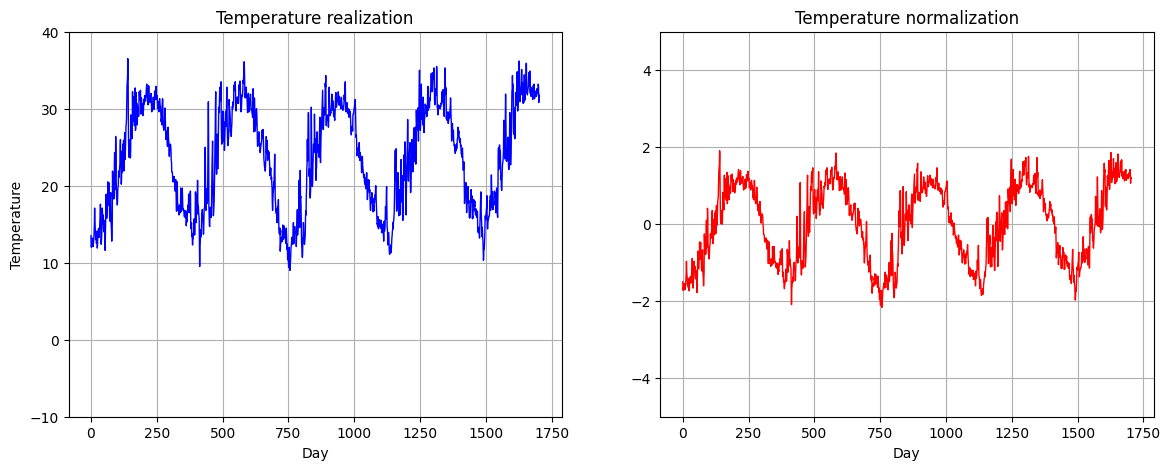

In [16]:
# Data Normalization Layer
class Normalize:
    def __init__(self, data: np.ndarray) -> None:
        self.data: np.ndarray = np.copy(data)
        self.__mean: np.ndarray = data.mean(axis=0)
        self.__std_dev: np.ndarray = data.std(axis=0)
        # Avoid dividing by zero
        self.__std_dev[self.__std_dev == 0] = 1.0

    def normalizeData(self) -> np.ndarray:
        return (self.data - self.__mean) / self.__std_dev

    def DeNormalizeData(self, normalized_data: np.ndarray, axes=None) -> np.ndarray:
        if axes is None:
            return normalized_data * self.__std_dev + self.__mean
        else:
            return normalized_data * self.__std_dev[axes] + self.__mean[axes]

train_normalize_class = Normalize(train_data[:, 1:])

normalized_data = train_normalize_class.normalizeData()  

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Set axis limits and labels
ax[1].set_ylim([-5, 5])  
ax[0].set_ylim([-10, 40])

ax[0].set_ylabel("Temperature")
ax[0].set_xlabel("Day")
ax[1].set_xlabel("Day")

ax[0].set_title("Temperature realization")
ax[1].set_title("Temperature normalization")

ax[0].grid()
ax[1].grid()

ax[0].plot(train_data[:, 1], c="b", linewidth=1)
ax[1].plot(normalized_data[:, 0], c="r", linewidth=1)

plt.show()

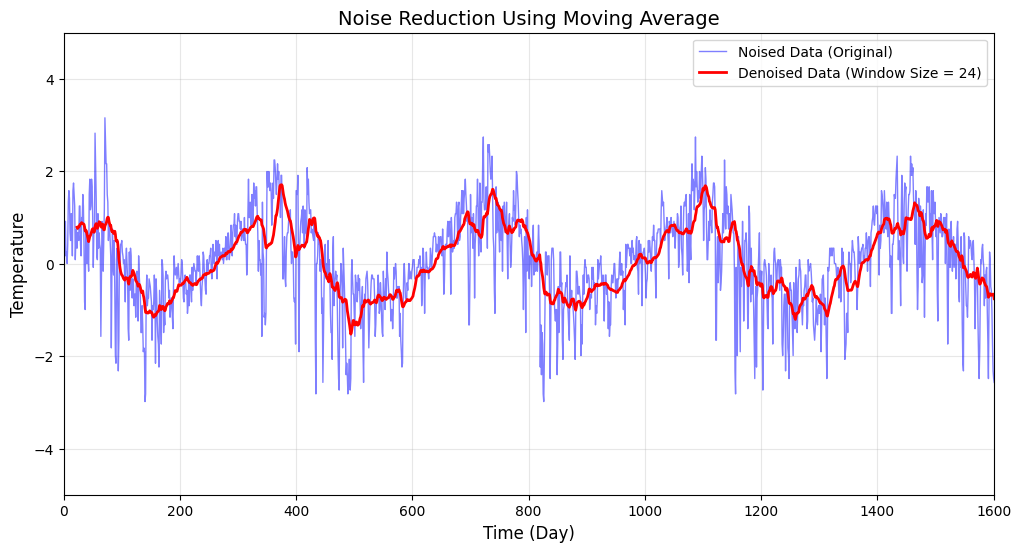

In [17]:
# smoothing data with moving average
def denoise_data(data: np.ndarray, window_size: int) -> np.ndarray:
    return pd.Series(data[:, 1]).rolling(window=window_size).mean().iloc[window_size - 1:].values

window_size = max(1, len(normalized_data) // 70)

denoised_train = denoise_data(normalized_data, window_size)

# Graph
plt.figure(figsize=(12, 6))  

# normalized data (noised data)
plt.plot(normalized_data[:, 1], 
         c="blue", 
         alpha=0.5,  
         linewidth=1, 
         label="Noised Data (Original)")

# smooted data (denoised data)
plt.plot(np.arange(window_size - 1, len(normalized_data)), 
         denoised_train, 
         c="red", 
         linewidth=2, 
         label=f"Denoised Data (Window Size = {window_size})")

plt.title("Noise Reduction Using Moving Average", fontsize=14)
plt.xlabel("Time (Day)", fontsize=12)
plt.ylabel("Temperature", fontsize=12)
plt.ylim(-5, 5)  
plt.xlim(0, 1600)
plt.grid(alpha=0.3)
plt.legend()  

plt.show()

In [23]:
# smoothing data with moving average
def denoise_data(data: np.ndarray, window_size: int) -> np.ndarray:
    return pd.Series(data).rolling(window=window_size).mean().iloc[window_size - 1:].values
    
# Caculate MAE
def MAE(predictions: np.ndarray, labels: np.ndarray) -> float:
    return np.mean(np.abs(predictions - labels))

# Find the main frequency by Fourier transform
def find_dominant_frequencies(data: np.ndarray, num_frequencies: int) -> np.ndarray:
    mfft: np.ndarray = np.fft.fft(data)
    imax: np.ndarray = np.argsort(np.absolute(mfft))[::-1]
    imax = imax[:num_frequencies]
    frequencies: np.ndarray = np.array(imax) / len(data)
    return frequencies

# processing for each city and parameter
def process_city_parameter(city_file: str, parameter: str, number_of_sinuses: int = 5, ratio: float = 0.9):
    # Read data
    print(f"Processing {os.path.basename(city_file)} - {parameter}...")
    df = pd.read_csv(city_file)
    
    # Check if parameter exists
    if parameter not in df.columns:
        print(f"  Parameter {parameter} is not present in the data")
        return None, None
    
    # Convert date
    df['days'] = df['date'].apply(days_since_zero_date)
    
    # Prepart data
    data = df[['days', parameter]].values
    data = data.astype('float')
    
    # Devide train/test
    index = int(data.shape[0] * ratio)
    train_data = data[:index]
    test_data = data[index:]
    
    # Normalize parameter data
    train_normalize_class = Normalize(train_data[:, 1].reshape(-1, 1))
    normalized_data = train_normalize_class.normalizeData().flatten()
    
    # Data Smoothing
    window_size = max(1, len(normalized_data) // 70)
    if len(normalized_data) <= window_size:
        print(f"  Not enough data for {parameter}")
        return None, None
    
    denoised_train = denoise_data(normalized_data, window_size)
    
    # Frequency calculation via Fourier transform
    x_data = np.linspace(0, len(denoised_train), len(denoised_train))
    frequencies = find_dominant_frequencies(denoised_train, number_of_sinuses)
    
    # Initialize parameters
    init_params = np.array([
        np.array([np.std(denoised_train), frequencies[i] * 2 * np.pi, 0.0])
        for i in range(number_of_sinuses)
    ])
    bias = np.mean(denoised_train)
    
    # Model
    class SinLayer(layers.Layer):
        def __init__(self):
            super(SinLayer, self).__init__()

        def build(self, _):
            self.kernel = self.add_weight(name="kernel", shape=(number_of_sinuses, 3), trainable=True)
            self.bias = self.add_weight(name="bias", shape=(), trainable=True)

        def call(self, inputs):
            result = 0
            for i in range(number_of_sinuses):
                result += self.kernel[i][0] * tf.sin(
                    self.kernel[i][1] * inputs + self.kernel[i][2]
                )
            return result + self.bias
    
    # Model Building
    inputs = keras.Input(shape=(1,))
    outputs = SinLayer()(inputs)
    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=0.001, beta_1=0.8, beta_2=0.9)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    
    # Set initial weights
    model.set_weights([init_params, bias])
    
    # Model training
    history = model.fit(x_data, denoised_train, epochs=50, verbose=0)
    
    # Prediction and assessment
    test_x = test_data[:, 0].reshape(-1, 1)
    predictions = model.predict(test_x, verbose=0)
    
    # Predictive Normalization
    denormalized_preds = train_normalize_class.DeNormalizeData(predictions, axes=[0]).flatten()
    
    # Caculate MAE
    mae = MAE(denormalized_preds, test_data[:, 1])
    
    print(f"  MAE for {parameter}: {mae:.4f}, Loss: {history.history['loss'][-1]:.4f}")
    
    return model, mae, history 

In [31]:
# Get the list of file CSV
cities_files = glob.glob('/kaggle/input/cities/*.csv')

# List of parameters to be modeled
parameters = ['temperature_avg', 'humidity_avg', 'wind_speed_max']

results = {}

for city_file in cities_files:
    city_name = os.path.basename(city_file).replace('.csv', '')
    results[city_name] = {'models': {}, 'metrics': {}, 'histories': {}} 
    
    for param in parameters:
        model, mae, history = process_city_parameter(city_file, param)
        if model is not None:
            results[city_name]['models'][param] = model
            results[city_name]['metrics'][param] = mae
            results[city_name]['histories'][param] = history

print("\nResult:")
for city_name, city_results in results.items():
    print(f"\n City: {city_name}")
    for param, mae in city_results['metrics'].items():
        print(f"  - {param}: MAE = {mae:.4f}")

Processing Ho Chi Minh City.csv - temperature_avg...
  MAE for temperature_avg: 0.7623, Loss: 0.2704
Processing Ho Chi Minh City.csv - humidity_avg...
  MAE for humidity_avg: 6.4312, Loss: 0.1730
Processing Ho Chi Minh City.csv - wind_speed_max...
  MAE for wind_speed_max: 4.1675, Loss: 0.1171
Processing Paris.csv - temperature_avg...
  MAE for temperature_avg: 4.7662, Loss: 0.0925
Processing Paris.csv - humidity_avg...
  MAE for humidity_avg: 11.4533, Loss: 0.1778
Processing Paris.csv - wind_speed_max...
  MAE for wind_speed_max: 7.8719, Loss: 0.1218
Processing Singapore.csv - temperature_avg...
  MAE for temperature_avg: 0.7284, Loss: 0.2009
Processing Singapore.csv - humidity_avg...
  MAE for humidity_avg: 3.3559, Loss: 0.1827
Processing Singapore.csv - wind_speed_max...
  MAE for wind_speed_max: 2.8938, Loss: 0.1175
Processing Sydney.csv - temperature_avg...
  MAE for temperature_avg: 2.2944, Loss: 0.0952
Processing Sydney.csv - humidity_avg...
  MAE for humidity_avg: 8.4240, Loss:

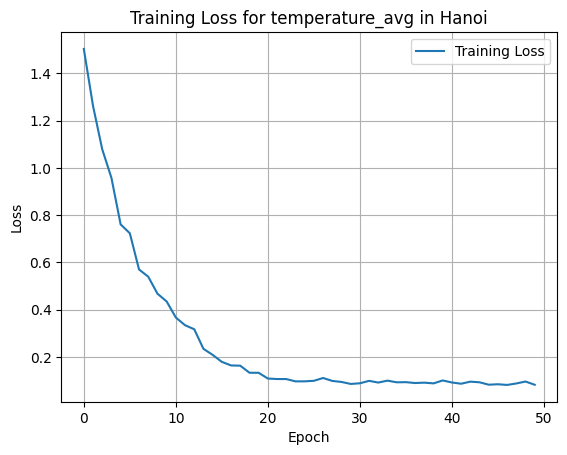

In [32]:
city_name = 'Hanoi'  
param = 'temperature_avg'

training_history = results[city_name]['histories'][param]

plt.plot(training_history.history['loss'], label='Training Loss')
plt.title(f'Training Loss for {param} in {city_name}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

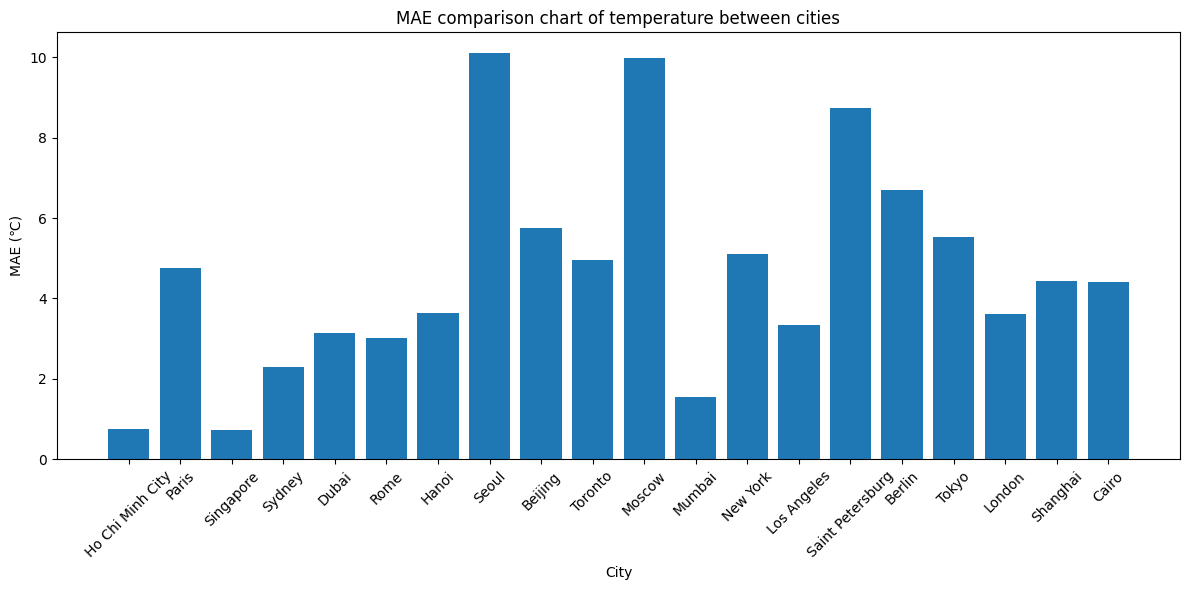

In [33]:
# MAE comparison chart of temperature between cities
cities = [city for city in results.keys() if 'temperature_avg' in results[city]['metrics']]
temps_mae = [results[city]['metrics']['temperature_avg'] for city in cities]

if cities and temps_mae:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_mae)
    plt.title('MAE comparison chart of temperature between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (℃)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

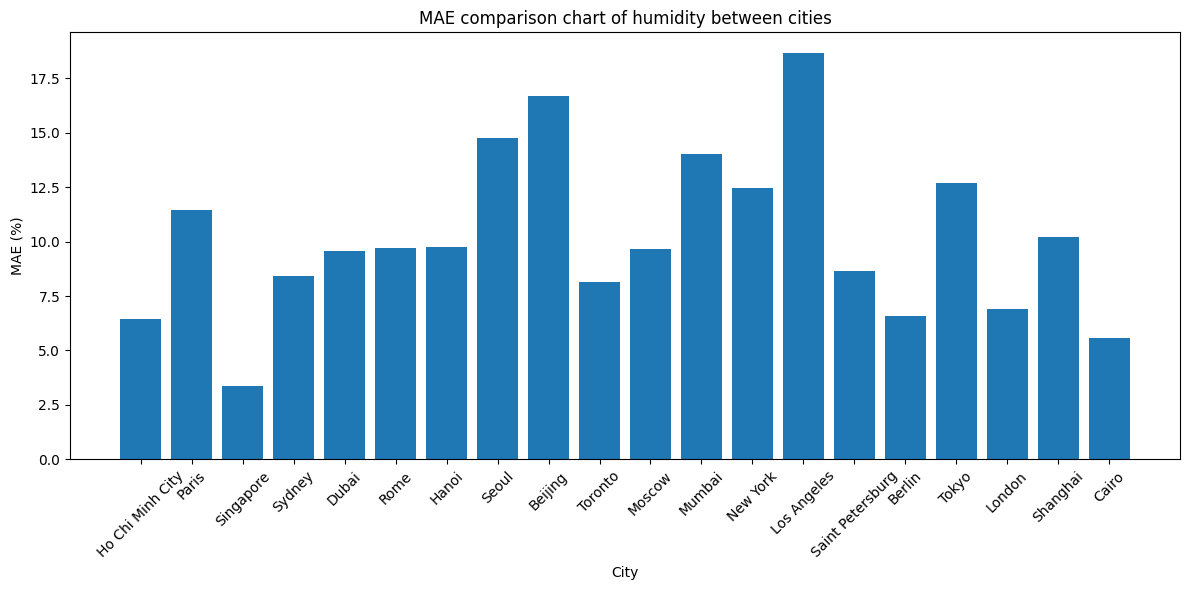

In [34]:
cities = [city for city in results.keys() if 'humidity_avg' in results[city]['metrics']]
temps_mae = [results[city]['metrics']['humidity_avg'] for city in cities]

if cities and temps_mae:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_mae)
    plt.title('MAE comparison chart of humidity between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

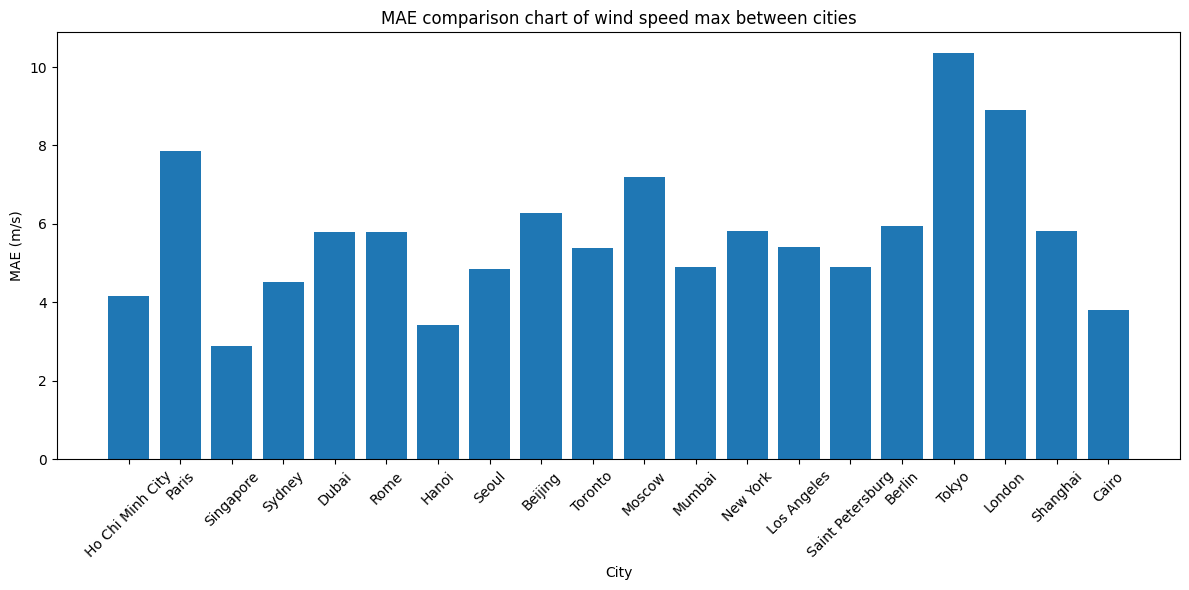

In [35]:
cities = [city for city in results.keys() if 'wind_speed_max' in results[city]['metrics']]
temps_mae = [results[city]['metrics']['wind_speed_max'] for city in cities]

if cities and temps_mae:
    plt.figure(figsize=(12, 6))
    plt.bar(cities, temps_mae)
    plt.title('MAE comparison chart of wind speed max between cities')
    plt.xlabel('City')
    plt.ylabel('MAE (m/s)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()